In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Library

In [3]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import csv
from collections import Counter

## Decision Tree Module

In [4]:
class Node:
    def __init__(self, feature = None, threshold = None, left = None, right = None, *, value = None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

In [5]:
class DecisionTree:
    def __init__(self, min_samples_split = 2, max_depth = 100, n_features = None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.root = None

    def fit(self, X, y):
        self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth = 0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(y))

        # Check the stopping criteria
        if ((depth >= self.max_depth) or (n_labels == 1) or (n_samples < self.min_samples_split)):
            leaf_value = self._most_common_label(y)
            return Node(value = leaf_value)
        feat_idxs = np.random.choice(n_feats, self.n_features, replace = False)
        # Find the best split
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)
        # Create child nodes
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, : ], y[right_idxs], depth + 1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # Calculate the information gain
                gain = self._information_gain(y, X_column, thr)

                if (gain > best_gain):
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        # Parent entropy
        parent_entropy = self._entropy(y)
        # Create children
        left_idxs, right_idxs = self._split(X_column, threshold)

        if ((len(left_idxs) == 0) or (len(right_idxs) == 0)):
            return 0

        # Calculate the weighted avg. Entropy of children
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l/n) * e_l + (n_r/n) * e_r

        # Calculate the IG
        information_gain = parent_entropy - child_entropy
        return information_gain

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs


    def _entropy(self, y):
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])


    def _most_common_label(self, y):
        counter = Counter(y)
        value  = counter.most_common(1)[0][0]
        return value


    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])


    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if (x[node.feature] <= node.threshold):
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

### Define function

In [7]:
def precessing_data(data):
    pre_data = []
    pre_target = [data.Survived[i] for i in range(len(data))]

    for i in range(0, len(data)):
        temp_data = []
        if (data.Sex[i] == "male"):
            temp_data.append(1)
        else:
            temp_data.append(0)
        temp_data.append(data.Age[i])
        temp_data.append(data.SibSp[i])
        temp_data.append(data.Parch[i])
        pre_data.append(temp_data)
    pre_data = np.array(pre_data)
    pre_target = np.array(pre_target)
    return pre_data, pre_target

In [8]:
def precessing_test(data):
    pre_data = []
    for i in range(0, len(data)):
        temp_data = []
        if (data.Sex[i] == "male"):
            temp_data.append(1)
        else:
            temp_data.append(0)
        temp_data.append(data.Age[i])
        temp_data.append(data.SibSp[i])
        temp_data.append(data.Parch[i])
        pre_data.append(temp_data)
    pre_data = np.array(pre_data)
    return pre_data

In [9]:
def write_submission(cd, submission_data):
    header = ["PassengerId", "Survived"]
    # open the file in the write mode
    f = open(cd, 'w')

    # create the csv writer
    writer = csv.writer(f)

    # write a row to the csv file
    writer.writerow(header)
    for i in range(0, len(submission_data)):
        writer.writerow(submission_data[i])

    # close the file
    f.close()

In [10]:
def handle_missing(data):
  data.Sex.fillna(Counter(train_data.Sex).most_common(1)[0][0],inplace=True)
  data.Age.fillna(Counter(train_data.Age).most_common(1)[0][0],inplace=True)
  data.SibSp.fillna(Counter(train_data.SibSp).most_common(1)[0][0],inplace=True)
  data.Parch.fillna(Counter(train_data.Parch).most_common(1)[0][0],inplace=True)
  return data

In [11]:
def accuracy(y_test, y_pred):
    return np.sum(y_test == y_pred) / len(y_test)

### Training

In [16]:
# Reading data
train_data = pd.read_csv("/content/drive/MyDrive/Machine Learning Code/Titanic - Machine Learning from Disaster/Data/train_data.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Machine Learning Code/Titanic - Machine Learning from Disaster/Data/test_data.csv")
# Hande missing data
train_data = handle_missing(train_data)
test_data = handle_missing(test_data)
# Create X and y
X, y = precessing_data(train_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)
# Set tree
clf = DecisionTree(max_depth = 4, n_features = 4)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
acc = accuracy(y_test, predictions)
print(acc)

0.8491620111731844


In [13]:
select = ["Age", "Sex", "SibSp", "Parch", "Survived"]
df = train_data[select]
df = df.sort_values(by=["Survived"], ignore_index = True)
#df["count"] = 1 342
#df = df.groupby("Survived").sum()
print(df.head(10))

    Age   Sex  SibSp  Parch  Survived
0  22.0  male      1      0         0
1  32.0  male      0      0         0
2  22.0  male      0      0         0
3  24.0  male      0      0         0
4  24.0  male      0      0         0
5  40.5  male      0      0         0
6  24.0  male      0      0         0
7  39.0  male      0      0         0
8  23.0  male      2      1         0
9  24.0  male      0      0         0


<ipython-input-14-182916205efb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Count"] = 1


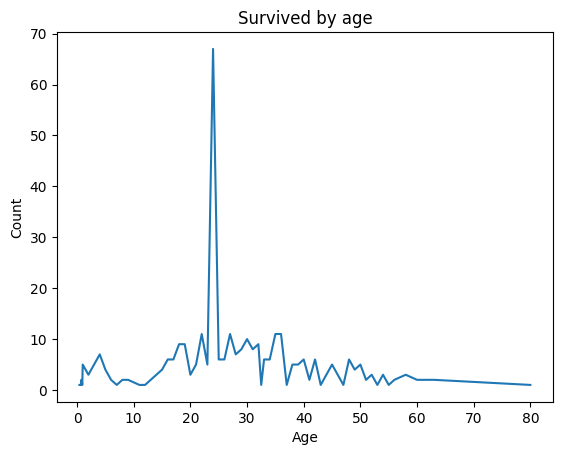

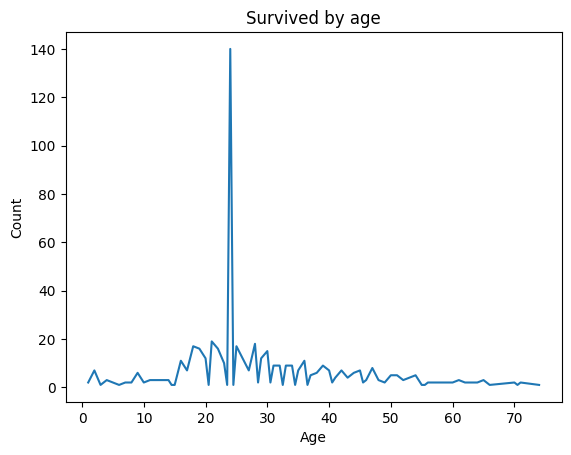

In [14]:
import matplotlib.pyplot as plt
select = ["Age", "Survived"]
df = train_data[select]
df["Count"] = 1

df_1 = df[df["Survived"] == 1].groupby("Age", as_index = False).sum()
x_axis = list(df_1["Age"])
y_axis = list(df_1["Count"])

plt.plot(x_axis, y_axis)
plt.title('Survived by age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

df_0 = df[df["Survived"] == 0].groupby("Age", as_index = False).sum()
x_axis = list(df_0["Age"])
y_axis = list(df_0["Count"])

plt.plot(x_axis, y_axis)
plt.title('Survived by age')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

<ipython-input-20-2dbc23aea329>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Count"] = 1


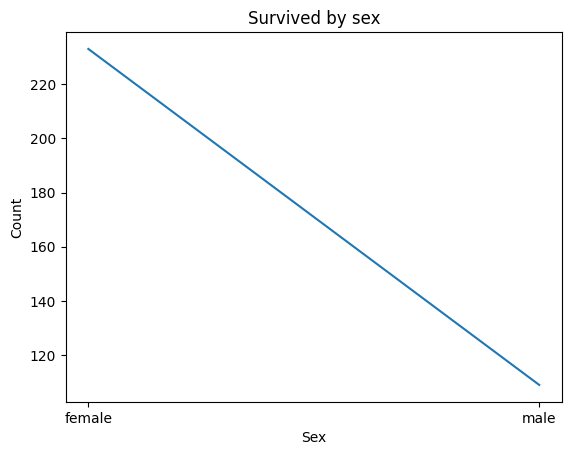

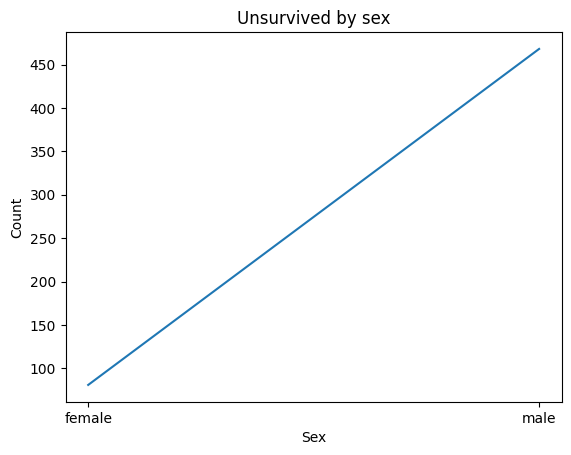

In [20]:
import matplotlib.pyplot as plt
select = ["Sex", "Survived"]
df = train_data[select]
df["Count"] = 1

df_1 = df[df["Survived"] == 1].groupby("Sex", as_index = False).sum()
x_axis = list(df_1["Sex"])
y_axis = list(df_1["Count"])

plt.plot(x_axis, y_axis)
plt.title('Survived by sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

df_0 = df[df["Survived"] == 0].groupby("Sex", as_index = False).sum()
x_axis = list(df_0["Sex"])
y_axis = list(df_0["Count"])

plt.plot(x_axis, y_axis)
plt.title('Unsurvived by sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

### Test

In [ ]:
X_test = precessing_test(test_data)
predictions = clf.predict(X_test)
submission_data = []
for i in range(0, len(predictions)):
    temp = []
    temp.append(i + 892)
    temp.append(predictions[i])
    submission_data.append(temp)
write_submission('/content/drive/MyDrive/Machine Learning Code/Titanic - Machine Learning from Disaster/Submit/Submission_DecisionTree', submission_data)

## Sklearn module

In [21]:
# Reading data
train_data = pd.read_csv("/content/drive/MyDrive/Machine Learning Code/Titanic - Machine Learning from Disaster/Data/train_data.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Machine Learning Code/Titanic - Machine Learning from Disaster/Data/test_data.csv")
# Hande missing data
train_data = handle_missing(train_data)
test_data = handle_missing(test_data)
# Create X and y
X, y = precessing_data(train_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)
# Set tree
clf = DecisionTreeClassifier(max_depth = 4, max_features = 4)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
acc = accuracy(y_test, predictions)
print(acc)

0.8435754189944135


In [35]:
print(len(y_train) - y_train.sum())
print(y_train.sum())

440
272


In [55]:
# Reading data
train_data = pd.read_csv("/content/drive/MyDrive/Machine Learning Code/Titanic - Machine Learning from Disaster/Data/train_data.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Machine Learning Code/Titanic - Machine Learning from Disaster/Data/test_data.csv")
# Hande missing data
train_data = train_data.sort_values(by = ["Survived"], ignore_index = True)
train_data = handle_missing(train_data)
test_data = handle_missing(test_data)
# Create X and y
X, y = precessing_data(train_data)

342
549
275


In [ ]:
# Set tree
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 65, random_state = 1234)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
acc = accuracy(y_test, predictions)
print(acc)

0.7988826815642458


In [ ]:
# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
select = ["Age", "Sex", "SibSp", "Parch"]
for i in range(3):
    tree = clf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names = train_data[select].columns,
                               filled=True,
                               max_depth = 5,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [ ]:
X_test = precessing_test(test_data)
predictions = clf.predict(X_test)
submission_data = []
for i in range(0, len(predictions)):
    temp = []
    temp.append(i + 892)
    temp.append(predictions[i])
    submission_data.append(temp)
write_submission('/content/drive/MyDrive/Machine Learning Code/Titanic - Machine Learning from Disaster/Submit/Submission_DecisionTree.csv', submission_data)